In [1]:
""" This notebook walks you through an example of how to write and run a deterministic age stratified SIR 
    model with the contact matrices we provide in this repository."""
import numpy as np
import pandas as pd
import matplotlib as mplt
import matplotlib.pyplot as plt

import copy
import os


# set the font family style
mplt.rcParams['font.family'] = 'Roboto Condensed'  # change to a font you have installed on your computer - checkout Google Fonts for free font available for download
mplt.rcParams['font.size'] = 22  # increase default font size

# set the random seed
seed = 0
np.random.seed(0)

In [2]:
# set some initial paths to the data folder and some other useful folders
# thisdir = os.path.abspath('')

# datadir = os.path.join(os.path.split(thisdir)[0], 'data')
# figdir = os.path.join(os.path.split(thisdir)[0], 'figures')

# # read in dataframes with location and associated country names
# location_file = os.path.join(datadir, 'location_country_names.csv')
# locations_df = pd.read_csv(location_file, delimiter = ',')


# # set the font family style
# mplt.rcParams['font.family'] = 'Myriad Pro'  # change to a font you have installed on your computer - checkout Google Fonts for free fonts available for download

# set some initial paths

# path to the directory where this script lives
thisdir = os.path.abspath('')

# path to the main directory of the repository
maindir = os.path.split(os.path.split(thisdir)[0])[0]

# path to the analysis_results subdirectory
analysisdir = os.path.split(thisdir)[0]

# path to the data subdirectory
datadir = os.path.join(os.path.split(os.path.split(thisdir)[0])[0], 'data')

# path to the figures subdirectory within analysis_results
figdir = os.path.join(analysisdir, 'figures')

location_file = os.path.join(analysisdir, 'location_country_names.csv')
locations_df = pd.read_csv(location_file, delimiter = ',')

In [3]:
def get_country_name(df,location):
    """
    Return country name of the location

    Args:
        df (pandas Dataframe) : dataframe containing locations and corresponding countries
        location (str)        : name of the location

    Returns:
        str: Name of the country the location is in.
    """
    d = df[df.location == location]
    return d.country.values[0]

In [4]:
def get_locations_by_country(df,country):
    """
    Return locations in the country

    Args:
        df (pandas Dataframe) : dataframe containing locations and corresponding countries
        country (str)         : name of the country

    Returns:
        str: Name of the country the location is in.
    """
    locations = list(df[df.country == country].location.values)
    return locations

In [5]:
def read_contact_matrix(location, country, level, setting, num_agebrackets=85):
    """
    Read in the contact for each setting.

    Args:
        location (str)        : name of the location
        country (str)         : name of the country
        level (str)           : name of level (country or subnational)
        setting (str)         : name of the contact setting
        num_agebrackets (int) : the number of age brackets for the matrix

    Returns:
        A numpy matrix of contact.
    """
    setting_type, setting_suffix = 'F', 'setting'
    if setting == 'overall':
        setting_type, setting_suffix = 'M', 'contact_matrix'

    if country == 'Europe':
        country = location
        level = 'country'
    if level == 'country':
        file_name = country + '_' + level + '_level_' + setting_type + '_' + setting + '_' + setting_suffix + '_' + '%i' % num_agebrackets + '.csv'
    else:
        file_name = country + '_' + level + '_' + location + '_' + setting_type + '_' + setting + '_' + setting_suffix + '_' + '%i' % num_agebrackets + '.csv'
    file_path = os.path.join(datadir, 'contact_matrices', file_name)
    return np.loadtxt(file_path, delimiter=',')

In [6]:
def get_contact_matrix_dic(location, country, level, num_agebrackets=85):
    """
    Get a dictionary of the setting contact matrices for a location.
    
    Args:
        location (str)        : name of the location
        country (str)         : name of the country
        level (str)           : name of level (country or subnational)
        num_agebrackets (int) : the number of age brackets for the matrix
    
    Returns:
        dict: A dictionary of the setting contact matrices for the location.
    """
    settings = ['household', 'school', 'work', 'community']
    matrix_dic = {}
    for setting in settings:
        matrix_dic[setting] = read_contact_matrix(location, country, level, setting, num_agebrackets)
    return matrix_dic

In [7]:
def get_ages(location, country, level, num_agebrackets=85):
    """
    Get the age count for the synthetic population of the location.

    Args:
        location (str)        : name of the location
        country (str)         : name of the country
        level (str)           : name of level (country or subnational)
        num_agebrackets (int) : the number of age brackets

    Returns:
        dict: A dictionary of the age count.
    """

    if country == 'Europe':
        country = location
        level = 'country'
    if level == 'country':
        file_name = country + '_' + level + '_level_age_distribution_' + '%i' % num_agebrackets + '.csv'
    else:
        file_name = country + '_' + level + '_' + location + '_age_distribution_' + '%i' % num_agebrackets + '.csv'
    file_path = os.path.join(datadir, 'age_distributions', file_name)
    df = pd.read_csv(file_path, delimiter=',', header=None)
    df.columns = ['age', 'age_count']
    return dict(zip(df.age.values.astype(int), df.age_count.values))

In [8]:
def get_eigenvalue(matrix):
    """
    Get the real component of the leading eigenvalue of a square matrix.

    Args:
        matrix (np.ndarray): square matrix

    Returns:
        float: Real component of the leading eigenvalue of the matrix.
    """
    eigenvalue = max(np.linalg.eigvals(matrix)).real
    return eigenvalue

In [9]:
def get_age_effective_contact_matrix_with_factor_vector(contact_matrix, susceptibility_factor_vector):
    """
    Get an effective age specific contact matrix with an age dependent susceptibility drop factor.

    Args:
        contact_matrix (np.ndarray)        : the contact matrix
        susceptibility_factor_vector (int): vector of age specific susceptibility, where the value 1 means fully susceptibility and 0 means unsusceptible.


    Returns:
        np.ndarray: A numpy square matrix that gives the effective contact matrix given an age dependent susceptibility drop factor.
    """
    effective_matrix = contact_matrix * susceptibility_factor_vector
    return effective_matrix

In [10]:
def get_R0_with_factor_vector(beta, susceptibility_factor_vector, num_agebrackets, gamma_inverse, contact_matrix):
    """
    Get the basic reproduction number R0 for a SIR compartmental model with an age dependent susceptibility drop factor and the age specific contact matrix.

    Args:
        beta (float)                              : the transmissibility
        susceptibility_factor_vector (np.ndarray) : vector of age specific susceptibility, where the value 1 means fully susceptibility and 0 means unsusceptible.
        num_agebrackets (int)                     : the number of age brackets of the contact matrix
        gamma_inverse (float)                     : the mean recovery period
        contact_matrix (np.ndarray)               : the contact matrix

    Returns:
        float: The basic reproduction number for a SIR compartmental model with an age dependent susceptibility drop factor and age specific contact patterns.
    """
    gamma = 1./gamma_inverse
    effective_matrix = get_age_effective_contact_matrix_with_factor_vector(contact_matrix.T, susceptibility_factor_vector)
    eigenvalue = get_eigenvalue( effective_matrix )
    R0 = beta * eigenvalue / gamma
    return R0

In [11]:
def get_beta_with_factor_vector(R0, susceptibility_factor_vector, num_agebrackets, gamma_inverse, contact_matrix):
    """
    Get the transmissibility beta for an SIR model with an age dependent susceptibility drop factor and the age specific contact matrix.

    Args:
        R0 (basic reproduction number)            : the basic reproduction number
        susceptibility_factor_vector (np.ndarray) : vector of age specific susceptibility, where the value 1 means fully susceptibility and 0 means unsusceptible.
        num_agebrackets (int)                     : the number of age brackets of the contact matrix
        gamma_inverse (float)                     : the mean recovery period
        contact_matrix (np.ndarray)               : the contact matrix

    Returns:
        float: The transmissibility beta for an SIR compartmental model with an age dependent susceptibility drop factor and age specific contact patterns.
    """
    gamma = 1./gamma_inverse
    effective_matrix = get_age_effective_contact_matrix_with_factor_vector(contact_matrix.T, susceptibility_factor_vector)
    eigenvalue = get_eigenvalue( effective_matrix )
    beta = R0 * gamma / eigenvalue
    return beta

In [12]:
def combine_synthetic_matrices(contact_matrix_dic, weights, num_agebrackets=85):
    """
    A linear combination of contact matrices for different settings to create an overall contact matrix given the weights for each setting.

    Args:
        contact_matrix_dic (dict) : a dictionary of contact matrices for different settings of contact. All setting contact matrices must be square and have the dimensions (num_agebrackets, num_agebrackets).
        weights (dict)            : a dictionary of weights for each setting of contact
        num_agebrackets (int)     : the number of age brackets of the contact matrix

    Returns:
        np.ndarray: A linearly combined overall contact matrix.
    """
    contact_matrix = np.zeros((num_agebrackets,num_agebrackets))
    for setting in weights:
        contact_matrix += contact_matrix_dic[setting] * weights[setting]
    return contact_matrix

In [13]:
def sir_with_age_specific_contact_matrix(contact_matrix_dic, weights, ages, beta, susceptibility_factor_vector, gamma_inverse, initial_infected_age, percent_of_initial_infected_seeds, num_agebrackets, timesteps):
    """
    Deterministic, compartmental, age stratified Susceptible-Infected-Recovered (SIR) model of infectious disease transmission in a population with age specific contact matrices and age specific susceptibility.

    Args:
        contact_matrix_dic (dict)                 : a dictionary of contact matrices for different settings of contact. All setting contact matrices must be square and have the dimensions (num_agebrackets, num_agebrackets).
        weights (dict)                            : a dictionary of weights for each setting of contact
        ages (dict)                               : a dictionary of the age count of people in the population
        beta (float)                              : the transmissibility
        susceptibility_factor_vector (np.ndarray) : vector of age specific susceptibility, where the value 1 means fully susceptibility and 0 means unsusceptible.
        # susceptibility_drop_factor (float)      : susceptibility drop factor
        # susceptibility_drop_age (int)           : age at which susceptibility drops
        gamma_inverse (float)                     : the mean recovery period
        initial_infected_age (int)                : the initial age seeded with infections
        percent_of_initial_infected_seeds (float) : percent of the population initially seeded with infections.
        num_agebrackets (int)                     : the number of age brackets of the contact matrix
        timesteps (int)                           : the number of timesteps
    
    Returns:
        A numpy array with the number of people in each disease state (S-I-R) by age for each timestep, a numpy array with the incidence by setting and age for each timestep, the disease state indices, and the setting indices.
    """

    gamma = 1./gamma_inverse
    total_population = sum(ages.values())
    initial_infected_number = min(total_population * percent_of_initial_infected_seeds, ages[initial_infected_age])
    num_agebrackets = len(ages)

    # simulation output
    states = np.zeros((3, num_agebrackets, timesteps + 1))
    incidence_by_setting = np.zeros((4, num_agebrackets, timesteps))

    # indices
    susceptible = 0
    infected = 1
    recovered = 2
    indices = {'susceptible': 0, 'infected': 1, 'recovered': 2}

    # setting indices
    household = 0
    school = 1
    work = 2
    community = 3
    setting_indices = {'household': 0, 'school': 1, 'work': 2, 'community': 3}

    settings = ['household', 'school', 'work', 'community']

    # initial conditions
    states[infected][initial_infected_age][0] = initial_infected_number
    for a in range(num_agebrackets):
        states[susceptible][a][0] = copy.deepcopy(ages[a]) - states[infected][a][0]

    age_effective_contact_matrix_dic = {}
    for setting in contact_matrix_dic:
        age_effective_contact_matrix_dic[setting] = get_age_effective_contact_matrix_with_factor_vector(contact_matrix_dic[setting], susceptibility_factor_vector)

    for t in range(timesteps):
        for i in range(num_agebrackets):
            for j in range(num_agebrackets):
                for k, setting in enumerate(settings):
                    incidence_by_setting[k][i][t] += beta * weights[setting] * age_effective_contact_matrix_dic[setting][i][j] * states[susceptible][i][t] * states[infected][j][t] / ages[j]

            states[susceptible][i][t+1] = states[susceptible][i][t] - incidence_by_setting[:, i, t].sum()
            states[infected][i][t+1] = states[infected][i][t] + incidence_by_setting[:, i, t].sum() - gamma * states[infected][i][t]
            states[recovered][i][t+1] = states[recovered][i][t] + gamma * states[infected][i][t]

    return states, incidence_by_setting, indices, setting_indices

In [14]:
# all countries available
countries = ['Australia', 'Canada', 'China', 'Europe', 'India', 'Israel', 'Japan', 'Russia', 'South_Africa', 'United_States']

# all subnational locations available, plus Israel
locations = []
for country in countries:
    locations += get_locations_by_country(locations_df, country)
    if country in locations and country != 'Israel':
        locations.remove(country)

    if country == 'India':
        locations.remove('Dadra_and_Nagar_Haveli')
        locations.remove('Chandigarh')
        locations.remove('Lakshadweep')

# or... instead choose just a handful of locations
locations = locations[::10]  # every 10th location

# SIR model parameters
num_agebrackets = 85  # number of age brackets for the contact matrices
R0_star = 1.6  # basic reproduction number
gamma_inverse = 2.6  # mean recovery period
initial_infected_age = 20  # some initial age to seed infections within the population
percent_of_initial_infected_seeds = 1e-5
timesteps = 350  # how long to run the SIR model

weights = {'household': 4.11, 'school': 11.41, 'work': 8.07, 'community': 2.79}  # effective setting weights as found in our study

# define the vector of susceptibility by age

# Example 1: past 18 the suseptibility of individuals drops to a relative factor of 0.6 of those under 18
susceptibility_factor_vector = np.ones((num_agebrackets, 1))
for a in range(18, num_agebrackets):
    susceptibility_factor_vector[a, :] *= 0.6
    
# # Example 2: under 18 the susceptibility of individuals drops to 0.2, from 18 to 65 the susceptibility is 0.8, and those 65 and over are fully susceptible to the disease.
# susceptibility_factor_vector = np.ones((num_agebrackets, 1))
# for a in range(0, 18):
#     susceptibility_factor_vector[a, :] *= 0.2
# for a in range(18, 65):
#     susceptibility_factor_vector[a, :] *= 0.8
    

# define a reference location - use the location you want to fix the basic reproduction number, and thus the reference beta for
reference_location = 'New_York'
reference_country = get_country_name(locations_df, reference_location)

if reference_location == 'Israel':
    reference_level = 'country'
else:
    reference_level = 'subnational'

# get the contact matrices for the reference location to calculate the reference beta
reference_contact_matrix_dic = get_contact_matrix_dic(reference_location, reference_country, reference_level, num_agebrackets)
reference_contact_matrix = combine_synthetic_matrices(reference_contact_matrix_dic, weights, num_agebrackets)
reference_beta = get_beta_with_factor_vector(R0_star, susceptibility_factor_vector, num_agebrackets, gamma_inverse, reference_contact_matrix)


# run the SIR model for a few locations 
R0_list = []
attack_rate_list = []
results_by_location = {}

for n, location in enumerate(locations):

    country = get_country_name(locations_df, location)
    if location == 'Israel':
        level = 'country'
    else:
        level = 'subnational'
    print(location)
    contact_matrix = read_contact_matrix(location, country, level, 'overall', num_agebrackets)
    contact_matrix_dic = get_contact_matrix_dic(location, country, level, num_agebrackets)
    ages = get_ages(location, country, level, num_agebrackets)
    

    R0 = get_R0_with_factor_vector(reference_beta, susceptibility_factor_vector, num_agebrackets, gamma_inverse, contact_matrix)
    states, incidence_by_setting, indices, setting_indices = sir_with_age_specific_contact_matrix(contact_matrix_dic, weights, ages, reference_beta,
                                         susceptibility_factor_vector,
                                         gamma_inverse, initial_infected_age, percent_of_initial_infected_seeds, num_agebrackets, timesteps)

    R0_list.append(R0)
    attack_rate_list.append(states[indices['recovered'], :, -1].sum() / sum(ages.values()) * 100)
    
    results_by_location[location] = {'states': states.copy(), 'incidence_by_setting': incidence_by_setting.copy()}

    

Australian_Capital_Territory
Manitoba
Yukon
Hebei
Ningxia
Yunnan
Slovenia
Estonia
Haryana
Himachal_Pradesh
Jammu_and_Kashmir
Israel
Gumma-ken
Kochi-ken
Oita-ken
Tokushima-ken
Altai_Republic
Chukotka
Kaluga_Oblast
Kostroma_Oblast
Moscow_Oblast
Oryol_Oblast
Samara_Oblast
Tuva
Yaroslavl_Oblast
Western_Cape
Florida
Maine
New_Hampshire
Puerto_Rico
West_Virginia


Text(0, 0.5, 'Attack Rate (%)')

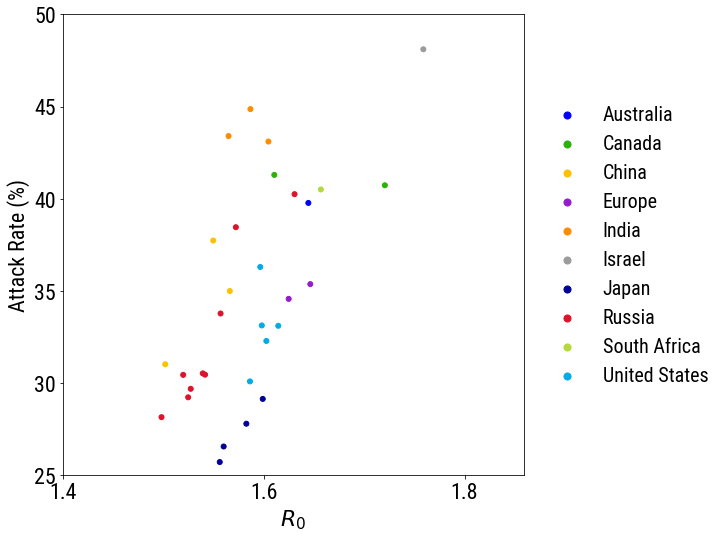

In [15]:
# Plot the attack rate vs R0
country_colour_dic = {}
country_colour_dic['Australia'] = '#0000ff'
country_colour_dic['Canada'] = '#2ab207'
country_colour_dic['China'] = '#fcc200'
country_colour_dic['Europe'] = '#941cca'
country_colour_dic['India'] = 'darkorange'
country_colour_dic['Israel'] = '#9b9b9b'
country_colour_dic['Japan'] = '#000098'
country_colour_dic['Russia'] = '#dc142b'
country_colour_dic['South_Africa'] = '#b5d93c'
country_colour_dic['United_States'] = '#00ace7'

color_list = [country_colour_dic[get_country_name(locations_df, location)] for n, location in enumerate(locations)]

size = 25

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
fig.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)
ax.scatter(R0_list, attack_rate_list, color=color_list, marker='o', s=size)

for country in ['Australia','Canada','China','Europe','India','Israel','Japan','Russia','South_Africa','United_States']:
    ax.scatter(np.nan, np.nan, color = country_colour_dic[country], s = size * 2, label = country.replace('-',' ').replace('_',' '))
leg = ax.legend(loc = 7, fontsize = 20, ncol = 1, bbox_to_anchor = (0.44,0.4,1,0.2))
leg.draw_frame(False)

xinterval = 0.2
xmin = 1.4
xmax = max(R0_list) + 0.1
ax.set_xlim(xmin, xmax)
ax.set_xticks(np.arange(xmin, xmax+0.01, 0.2))

yinterval = 5
ymin = int(min(attack_rate_list)/yinterval) * yinterval
ymax = (int(max(attack_rate_list)/yinterval) + 1) * yinterval
ax.set_ylim(ymin, ymax)
ax.set_yticks(np.arange(ymin, ymax+1, yinterval))
ax.tick_params(labelsize=22)

ax.set_xlabel(r'$R_0$', fontsize = 22)
ax.set_ylabel('Attack Rate (%)', fontsize = 22)

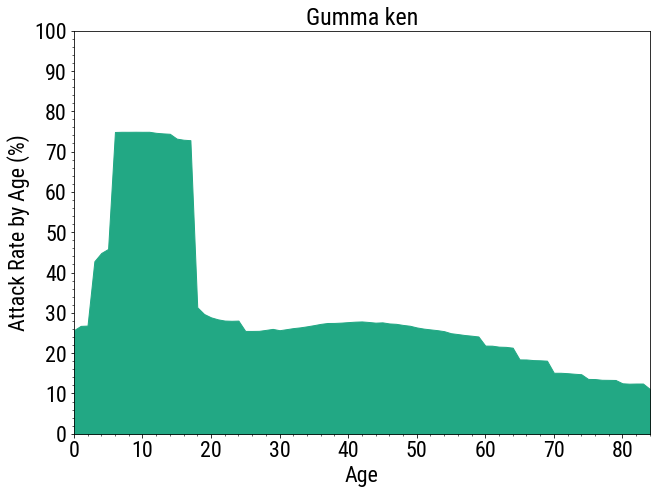

In [16]:
# Plot the attack rate by age for one location
color_list = [country_colour_dic[get_country_name(locations_df, location)] for n, location in enumerate(locations)]

fig, ax = plt.subplots(1, 1, figsize=(10, 7))
fig.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)

location = np.random.choice(list(results_by_location.keys()))  # choose one location
country = get_country_name(locations_df, location)

if location == 'Israel':
    level = 'country'
else:
    level = 'subnational'
ages = get_ages(location, country, level, num_agebrackets)

a_range = np.arange(num_agebrackets)
attack_rates_by_age = [results_by_location[location]['states'][indices['recovered'], a, -1] / ages[a] * 100 for a in a_range]

cmap = plt.get_cmap('viridis')
color = cmap(0.6)
ax.fill_between(x=a_range, y1=0, y2=attack_rates_by_age, color=color)

ax.set_xlim(0, num_agebrackets-1)
ax.set_xticks(np.arange(0, num_agebrackets, 10))

yinterval = 10
ax.set_ylim(0, 100)
ax.set_yticks(np.arange(0, 101, yinterval))
ax.set_title(location.replace('_', ' ').replace('-', ' '), fontsize=24)

ax.set_xlabel('Age', fontsize = 22)
ax.set_ylabel('Attack Rate by Age (%)', fontsize = 22)
ax.tick_params(labelsize=22)

plt.minorticks_on()